In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.stats import sem, t
from scipy import mean
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class BayesParzen:

  def __init__(self, h = 0.1):
    self.h = h

  def get_params(self, deep=True):
    return {"h": self.h}

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

  def fit(self, X, y):
    n_samples, n_features = X.shape
    self._classes = np.unique(y)
    n_classes = len(self._classes)
    self.n = n_samples

    # calcula a média, variância e a prior de cada classe
    self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
    self._var = np.zeros((n_classes, n_features), dtype=np.float64)
    self._priors =  np.zeros(n_classes, dtype=np.float64)

    for idx, c in enumerate(self._classes):
      X_c = X[y==c]
      self._mean[idx, :] = X_c.mean(axis=0)
      self._var[idx, :] = X_c.var(axis=0)
      self._priors[idx] = X_c.shape[0] / float(n_samples)

  def predict(self, X):
    y_pred = [self._predict(x) for x in X]
    return np.array(y_pred)

  def _predict(self, x):
    posteriors = []
    #Calcula a probabilidade posterior de cada class
    for idx, c in enumerate(self._classes):
      prior = np.log(self._priors[idx])
      posterior = prior + (np.log(self.multivariatePDF(idx, x)))
      posteriors.append(posterior)
      
    # retorna a maior probabilidade a posteriori
    return np.argmax(posteriors)

  # Função de kernel multivariada       
  def multivariatePDF(self, class_idx, x):
    p = (1/self.n) * (1/h) *  np.sum(np.prod(self.gaussian1D(class_idx, x)))
    return p
  
  def gaussian1D(self, class_idx, x):
    mean = self._mean[class_idx]
    var = self._var[class_idx]
    g1d = 1/np.sqrt(2 * np.pi * var) * np.exp(-(x - mean)**2/(2 * var))
    return g1d

  def predictProba(self, X):
    prob = [self._predictProba(x) for x in X]
    return np.array(prob)

  def _predictProba(self, x):
      posteriors = []

       #Calcula a probabilidade posterior de cada class
      for idx, c in enumerate(self._classes):
        prior = np.log(self._priors[idx])
        posterior = prior + (np.log(self.multivariatePDF(idx, x)))
        posteriors.append(posterior)

      # retorna as probabilidades a posteriori
      return posteriors

In [ ]:
view1 = pd.read_csv(r'https://raw.githubusercontent.com/jsaj/MachineLearning/master/mfeat-fac.csv',header=None, delim_whitespace=True)
view1 = preprocessing.normalize(view1, 'max')

view2 = pd.read_csv(r'https://raw.githubusercontent.com/jsaj/MachineLearning/master/mfeat-fou.csv',header=None, delim_whitespace=True)
view2 = preprocessing.normalize(view2, 'max')

view3 = pd.read_csv(r'https://raw.githubusercontent.com/jsaj/MachineLearning/master/mfeat-kar.csv',header=None, delim_whitespace=True)
view3 = preprocessing.normalize(view3, 'max')

target = pd.read_csv(r'https://raw.githubusercontent.com/jsaj/MachineLearning/master/cluster_membership_tres_m.csv',header=None, delim_whitespace=True)

X1 = view1
X2 = view2
X3 = view3

y = target[target.columns[0]]

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split (X1,y)
X_train2, X_test2, y_train2, y_test2 = train_test_split (X2,y)
X_train3, X_test3, y_train3, y_test3 = train_test_split (X3,y)

Xtrain = [X_train1, X_train2, X_train3]
ytrain = [y_train1, y_train2, y_train3]

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Scores:  0.7333333333333333
O H ótimo é 0.2


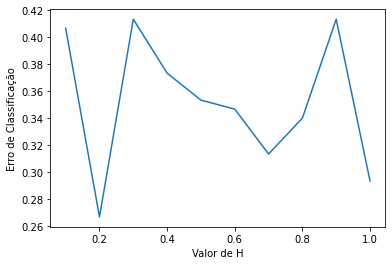

Scores:  0.5466666666666666
O H ótimo é 0.6


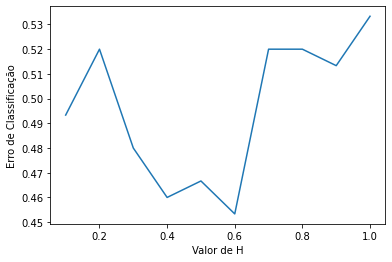

Scores:  0.7133333333333334
O H ótimo é 0.1


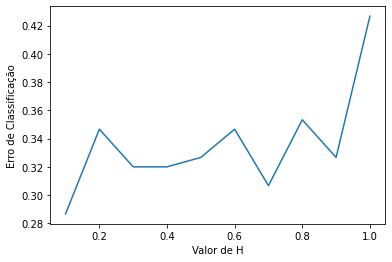

In [ ]:
bandwidths = np.linspace(0.1, 1, 10)
print (bandwidths)
H = []
for i in range(len(Xtrain)):
  for h in bandwidths:
    nb = BayesParzen(h = h)
    scores = cross_val_score(nb, Xtrain[i], ytrain[i], cv=10, scoring='accuracy')

  mse = [1 - x for x in scores]
  print ("Scores: ", max(scores))
  # determina o melhor h
  optimal_h = bandwidths[mse.index(min(mse))] 
  print("O H ótimo é {}".format(optimal_h))
  H.append(optimal_h)

  # plot erro de classificação vs h
  plt.plot(bandwidths, mse)
  plt.xlabel("Valor de H")
  plt.ylabel("Erro de Classificação")
  plt.show()

In [ ]:
def predictSoma(pred, X_test1, y_test):
    soma = []
    p = []
    sum = 0
    y_pred = []
    _classes = np.unique(y)
    priors = []
    for x in range (len(X_test1)):
      for idx, c in enumerate(_classes):
          nj = np.count_nonzero(y_test == idx)
          priori = nj/len(y_test)
          priors.append(priori)
          for clf in range(3):
            sum = sum + pred[x][clf][idx]
          soma.append(sum)
          sum = 0
          aux = ((1-3)*priors[idx] + soma[idx])
          p.append(aux)
      soma=[]
      y_pred.append(np.argmax(p))
      p=[]
    return np.array(y_pred)

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=30)
scores = []
for train_index, test_index in rskf.split(X1,y):
    X_train1, X_test1 = X1[train_index], X1[test_index]
    X_train2, X_test2 = X2[train_index], X2[test_index]
    X_train3, X_test3 = X3[train_index], X3[test_index]
    
    y_train, y_test = y[train_index], y[test_index]
    
    model1 = BayesParzen(H[0])
    model2 = BayesParzen(H[1])
    model3 = BayesParzen(H[2])

    model1.fit (X_train1, y_train) 
    model2.fit (X_train2, y_train) 
    model3.fit (X_train3, y_train) 

    pred1 = model1.predictProba(X_test1)
    pred2 = model2.predictProba(X_test2) 
    pred3 = model3.predictProba(X_test3)
    pred = [[pred1[x], pred2[x], pred3[x]]  for x in range (len(X_test1))]
    
    y_pred = predictSoma(pred, X_test1, y_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)
   

In [ ]:
print(scores)

[0.76, 0.695, 0.735, 0.665, 0.695, 0.66, 0.655, 0.72, 0.695, 0.7, 0.675, 0.71, 0.685, 0.73, 0.74, 0.695, 0.71, 0.68, 0.67, 0.69, 0.7, 0.695, 0.69, 0.68, 0.74, 0.68, 0.645, 0.705, 0.755, 0.67, 0.75, 0.655, 0.7, 0.69, 0.71, 0.705, 0.665, 0.71, 0.705, 0.7, 0.705, 0.675, 0.735, 0.71, 0.685, 0.75, 0.695, 0.635, 0.67, 0.72, 0.67, 0.715, 0.67, 0.675, 0.725, 0.695, 0.695, 0.705, 0.71, 0.7, 0.635, 0.67, 0.705, 0.72, 0.715, 0.725, 0.695, 0.685, 0.755, 0.675, 0.725, 0.655, 0.745, 0.73, 0.66, 0.71, 0.65, 0.68, 0.735, 0.7, 0.66, 0.75, 0.7, 0.705, 0.705, 0.675, 0.72, 0.7, 0.705, 0.64, 0.73, 0.695, 0.72, 0.7, 0.66, 0.73, 0.675, 0.685, 0.68, 0.7, 0.67, 0.665, 0.69, 0.655, 0.69, 0.725, 0.735, 0.71, 0.695, 0.71, 0.705, 0.725, 0.69, 0.705, 0.715, 0.68, 0.675, 0.725, 0.675, 0.665, 0.69, 0.74, 0.655, 0.64, 0.705, 0.68, 0.705, 0.745, 0.665, 0.765, 0.68, 0.685, 0.765, 0.65, 0.665, 0.71, 0.695, 0.715, 0.675, 0.77, 0.65, 0.68, 0.71, 0.675, 0.705, 0.72, 0.7, 0.695, 0.705, 0.715, 0.675, 0.7, 0.695, 0.695, 0.665,

In [ ]:
confidence = 0.95

n = len(scores)
m = mean(scores)
print ("Estimativa Pontual: ", m)
std_err = sem(scores)
print ("Erro médio: ", std_err)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)


start = m - h
end = m + h
print ("Intervalo de Confiança: entre {} e {}".format (start, end))

Estimativa Pontual:  0.6956666666666667
Erro médio:  0.0016048167000171788
Intervalo de Confiança: entre 0.6925085002692912 e 0.6988248330640421
